In [30]:
import matplotlib.pyplot as plt

contents = None
with open("log_2.txt", "r") as f:
    contents = [ i for i in f.readlines() if i.startswith("FOUND") ]

bugs_simreq = []
bugs_dse = []
difference = []
for line in contents:
    dse, simreq = float(line[6:11]), float(line[12:17])
    bugs_dse.append(dse)
    bugs_simreq.append(simreq)
    difference.append(simreq - dse)

(array([  4., 431., 177.,  88.,   0.,  34.,  11.,   1.,   2.,   1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

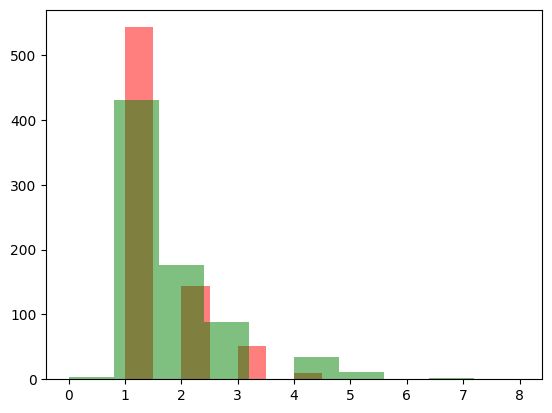

In [36]:
plt.hist(bugs_dse, color="red", alpha=0.5)
plt.hist(bugs_simreq, color="green", alpha=0.5)

(array([ 15., 584.,  84.,  41.,   0.,  15.,   6.,   2.,   1.,   1.]),
 array([-1. , -0.2,  0.6,  1.4,  2.2,  3. ,  3.8,  4.6,  5.4,  6.2,  7. ]),
 <BarContainer object of 10 artists>)

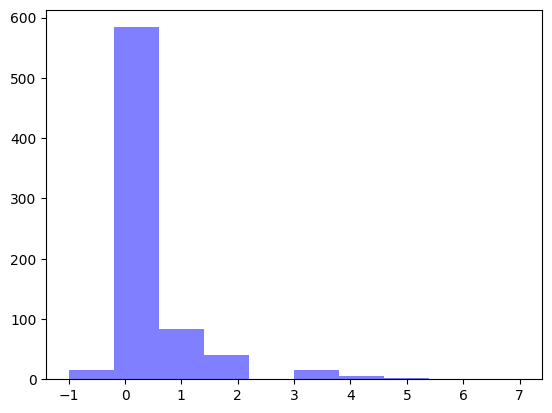

In [35]:
plt.hist(difference, color="blue", alpha=0.5)

In [ ]:
import 